In [2]:
import math,os,random,cv2,numpy as np,torch
import torch.nn as nn
from ultralytics import YOLO

<img src="../../Architecture/Images/yolov8_architecture.jpg" alt="image" width="600"/>

In [3]:
model_n = YOLO('yolov8m.pt')
print(f"yolov8-nano: {sum(p.numel() for p in model_n.parameters())/1e6} million parameters")
# print(model_n.model)

100%|██████████| 49.7M/49.7M [00:45<00:00, 1.16MB/s]


yolov8-nano: 25.90264 million parameters


# 1. Backkbone
- The bcakbone is modified CSPDarknet53 which comprises of blocks Conv, C2f, SPPF
- C2f (cross-stage partial bottleneck with 2 convolutions): Conv + bottlenecks + Conv 
Combine high-level features with contextual information to improve detection accuracy
- SPPF (spatial pyramid pooling fast): Conv + Maxpool2d + Conv, 
processes features at various scales and pool them into a fixed feature-map

<img src="../../Architecture/Images/yolov8_special_blocks.jpg" alt="image" width="600"/>


### (a) Conv


In [ ]:
class Conv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, groups = 1, activation = True):
        super().__init__()
        self.Conv = nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,bias = False,groups = groups)
        self.bn = nn.BatchNorm2d(out_channels,eps = 0.001,momentum=0.03)
        self.act = nn.SiLU(inplace=True) if activation else nn.Identity()
    
    def forward(self,x):
        return self.act(self.bn(self.Conv(x)))

In [5]:
#sanity check for conv block
import torch
x = torch.randn(1, 3, 224, 224)
conv_block = Conv(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
output = conv_block(x)

print(output.shape) 
l=sum(p.numel() for p in conv_block.parameters())
print(l)


torch.Size([1, 16, 224, 224])
464


### (b) C2f

In [6]:
# 2.1 Bottleneck: stack of 2 Conv with shortcut connection (True/Fals)

class Bottleneck(nn.Module):
    def __init__(self,in_channels,out_channels,shortcut = True):
        super().__init__()
        self.conv1 = Conv(in_channels,out_channels,kernel_size=3,stride = 1,padding=1)
        self.conv2 = Conv(out_channels,out_channels,kernel_size=3,stride = 1,padding=1)
        self.shortcut = shortcut
    
    def forward(self,x):
        x_in = x # for residual connection
        x = self.conv1(x)
        x = self.conv2(x)
        if self.shortcut:
            x=x+x_in
        return x

# 2.2 C2f: Conv + Bottleneck*n + Conv

class C2f(nn.Module):
    def __init__(self,in_channels,out_channels,num_bottlenecks,shortcut = True):
        super().__init__()
        self.mid_channels = out_channels//2
        self.num_bottlenecks = num_bottlenecks
        self.conv1 = Conv(in_channels,out_channels,kernel_size=1,stride=1,padding=0)
        self.m = nn.ModuleList([Bottleneck(self.mid_channels,self.mid_channels) for _ in range(num_bottlenecks)])
        self.conv2 = Conv((num_bottlenecks+2)*out_channels//2, out_channels, kernel_size=1,stride=1,padding=0)

    def forward(self,x):
        x = self.conv1(x)

        x1,x2 = x[:,:x.shape[1]//2,:,:],x[:,x.shape[1]//2:,:,:]
        outputs=[x1,x2] # x1 is fed to the bottlenecks
        for i in range( self.num_bottlenecks):
            x1 = self.m[i](x1) # [bs,0.5c_out,w,h]
            outputs.insert(0,x1)
        
        outputs=torch.cat(outputs,dim=1) #[bs,0.5c_out(num_bottlenecks+2),w,h]
        out = self.conv2(outputs)
        return out

# sanity check
c2f = C2f(in_channels=64,out_channels=128,num_bottlenecks=2)
print(f"{sum(p.numel() for p in c2f.parameters())/1e6} million parameters")

dummy_input = torch.rand((1,64,244,244))
dummy_output = c2f(dummy_input)
print("Output shape: ",dummy_output.shape)


0.18944 million parameters
Output shape:  torch.Size([1, 128, 244, 244])


In [7]:
class SPPF(nn.Module):
    def __init__(self,in_channels,out_channels,kernal_size=5):
        # kernal_size = sie of maxpool
        super().__init__()
        hidden_channels = in_channels//2
        self.conv1 = Conv(in_channels,hidden_channels,kernel_size=1,stride=1,padding=0)
        # concatenate    outputs of maxpool and feed to conv2
        self.conv2 = Conv(4*hidden_channels,out_channels,kernel_size=1,stride=1,padding=0)
        # maxpool is applied at 3 different scales
        self.m = nn.MaxPool2d(kernel_size=kernal_size, stride = 1, padding=kernal_size//2,dilation=1,ceil_mode=False)

    def forward(self,x):
        x = self.conv1(x)

        # apply maxpooling at different scales
        y1 = self.m(x)
        y2 = self.m(y1)
        y3 = self.m(y2)

        # concatenate
        y=torch.cat([x,y1,y2,y3],dim=1)

        #final conv
        y = self.conv2(y)   
        return y

sppf = SPPF(in_channels=128,out_channels=512)
print(f"{sum(p.numel() for p in sppf.parameters())/1e6} million parameters")

dummy_input = torch.rand((1,128,244,244))
dummy_output = sppf(dummy_input)
print("Output shape: ",dummy_output.shape)

0.140416 million parameters
Output shape:  torch.Size([1, 512, 244, 244])


[<Axes: >, <Axes: >]

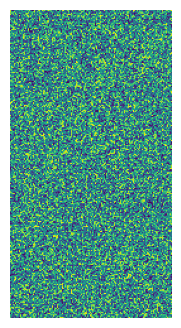

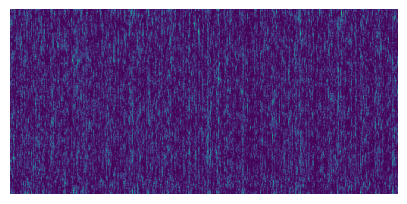

In [8]:
import torch, torch.nn as nn
from fastai.vision.all import show_image

img1 = dummy_input.detach().squeeze(0)  # Shape: [C, H, W]
img2 = dummy_output.detach().squeeze(0)  # Shape: [C, H, W]

img1 = img1.permute(1, 2, 0).cpu().numpy()  # Shape: [H, W, C]
img2 = img2.permute(1, 2, 0).cpu().numpy()  # Shape: [H, W, C]

list(map(lambda t: show_image(t[0]),[img1,img2]))

### Putting Backbone together

In [9]:
2/3

0.6666666666666666

In [10]:
#backbone = Darknet53

# return d,w,r based on version

def yolo_params(version):
    if version == 'n':
        return 1/3,1/4,2.0
    elif version == 's':
        return 1/3,1/2,2.0
    elif version == 'm':
        return 2/3,3/4,1.5
    elif version == 'l':
        return 1.0,1.0,1.0
    elif version == 'x':
        return 1.0,1.25,1.0

class BackBone(nn.Module):
    def __init__(self,version,in_channels=3,shortcut=True):
        super().__init__()
        d,w,r = yolo_params(version)

        #conv layers
        self.conv_0 = Conv(in_channels,int(64*w),kernel_size=3,stride=2,padding=1)
        self.conv_1 = Conv(int(64*w),int(128*w),kernel_size=3,stride=2,padding=1)
        self.conv_3 = Conv(int(128*w),int(256*w),kernel_size=3,stride=2,padding=1)
        self.conv_5 = Conv(int(256*w),int(512*w),kernel_size=3,stride=2,padding=1)
        self.conv_7 = Conv(int(512*w),int(512*w*r),kernel_size=3,stride=2,padding=1)

        #c2f layers
        self.c2f_2 = C2f(int(128*w),int(128*w),num_bottlenecks=int(3*d),shortcut=True)
        self.c2f_4 = C2f(int(256*w),int(256*w),num_bottlenecks=int(6*d),shortcut=True)
        self.c2f_6 = C2f(int(512*w),int(512*w),num_bottlenecks=int(6*d),shortcut=True)
        self.c2f_8 = C2f(int(512*w*r),int(512*w*r),num_bottlenecks=int(3*d),shortcut=True)

        #sppf layers
        self.sppf_9 = SPPF(int(512*w*r),int(512*w*r))
    
    def forward(self,x):

        x = self.conv_0(x)
        x = self.conv_1(x)
        x = self.c2f_2(x)
        x = self.conv_3(x)
        out1 = self.c2f_4(x)
        x = self.conv_5(out1)
        out2 = self.c2f_6(x)
        x = self.conv_7(out2)
        x = self.c2f_8(x)
        out3 = self.sppf_9(x)

        return out1,out2,out3
    
print("----Nano Model -----")
backbone_n = BackBone(version='n')
print(f"{sum(p.numel() for p in backbone_n.parameters())/1e6} million parameters")

print("----Large Model -----")
backbone_l = BackBone(version='l')
print(f"{sum(p.numel() for p in backbone_l.parameters())/1e6} million parameters")



----Nano Model -----
1.272656 million parameters
----Large Model -----
19.808576 million parameters


In [11]:
# sanity check
x = torch.randn((1,3,640,640))
out1,out2,out3 = backbone_n(x)
print(out1.shape)
print(out2.shape)
print(out3.shape)

torch.Size([1, 64, 80, 80])
torch.Size([1, 128, 40, 40])
torch.Size([1, 256, 20, 20])


# Neck

### The neck comprises of Upsample + C2f with 
Upsample = nearest-neighbor interpolation with scale-factor = 2. It doesn't have trainable parameters

In [12]:
class Upsample(nn.Module):
    def __init__(self, scale_factor=2, mode='nearest'):
        super().__init__()
        self.scale_factor = scale_factor
        self.mode = mode

    def forward(self,x):
        return nn.functional.interpolate(x,scale_factor=self.scale_factor,mode=self.mode)

In [13]:
class Neck(nn.Module):
    def __init__(self, version):
        super().__init__()
        d,w,r = yolo_params(version)

        self.up = Upsample()
        self.c2f_12 = C2f(in_channels=int(512*w*(1+r)),out_channels=int(512*w),num_bottlenecks=int(3*d),shortcut=False)
        self.c2f_15 = C2f(in_channels=int(768*w),out_channels=int(256*w),num_bottlenecks=int(3*d),shortcut=False)
        self.c2f_18 = C2f(in_channels=int(768*w),out_channels=int(512*w),num_bottlenecks=int(3*d),shortcut=False)
        self.c2f_21 = C2f(in_channels=int(512*w*(1+r)),out_channels=int(512*w*r),num_bottlenecks=int(3*d),shortcut=False)

        self.conv_16 = Conv(in_channels=int(256*w),out_channels=int(256*w), kernel_size=3, stride=2, padding=1)
        self.conv_19 = Conv(in_channels=int(512*w),out_channels=int(512*w), kernel_size=3, stride=2, padding=1)

    def forward(self, x_res1, x_res2, x):
        # x_res1, x_res2, x = output of backbone
        res_1 = x # for residual connection
        x = self.up(x)
        x=torch.cat([x,x_res2],dim=1)

        res_2 = self.c2f_12(x) # for residual connection
        
        x = self.up(res_2)
        x = torch.cat([x,x_res1],dim=1)

        out_1 = self.c2f_15(x)

        x = self.conv_16(out_1)
        x = torch.cat([x,res_2],dim=1)
        
        out_2 = self.c2f_18(x)

        x = self.conv_19(out_2)
        x = torch.cat([x,res_1],dim=1)

        out_3 = self.c2f_21(x)
        return out_1,out_2,out_3



In [14]:
# sanity check
neck = Neck(version='n')
print(f"{sum(p.numel() for p in neck.parameters())/1e6} million parameters")

x = torch.rand((1,3,640,640))
out1,out2,out3 = BackBone(version='n')(x)
out_1,out_2,out_3 = neck(out1,out2,out3)
print(out_1.shape)
print(out_2.shape)
print(out_3.shape)

0.98688 million parameters
torch.Size([1, 64, 80, 80])
torch.Size([1, 128, 40, 40])
torch.Size([1, 256, 20, 20])


# Head

consist of 3 modules: (1) bbox cordinates, (2) classification scores, (3) distribution focal loss (DFL).

DFL considers the predicted bbox coordinates as a probability distribution. At inference time, 
it samples from the distribution to get refined coordinates (x,y,w,h). For example, to 
predict coordinate x in the normalized range[0,1]:

    1. DFL uses 16 bins which are equally spaced in [0,1], bin length = 1/16
    2. The model outputs 16 numbers which corresponds to probabilities that x falls in these 
       bins, for example, [0,0,....,9/10,1/10].
    3. Prediction for x = mean value = 9/10 * 15/16 + 1/10 * 1 = 0.94375


In [15]:
# DFL

class DFL(nn.Module):
    def __init__(self,ch=16):
        super().__init__()
        self.ch = ch
        self.conv = nn.Conv2d(in_channels=ch,out_channels=1,kernel_size=1,bias=False).requires_grad_(False)

        # initialise conv with [0,...,ch-1]
        x = torch.arange(ch,dtype=torch.float).view(1,ch,1,1)
        self.conv.weight.data[:] = torch.nn.Parameter(x) # DFL only has ch parameters
    def forward(self,x):
        # x must have num_channels = 4*ch: x=[bs, 4*ch, c]
        b, c, a = x.shape                           # c = 4*ch
        x = x.view(b, 4, self.ch, a).transpose(1,2) # [bs, ch, 4,  a]

        # take softmax on channel dimension to get distribution probabilities
        x = x.softmax(1)            # [b, ch, 4, a]
        x = self.conv(x)            # [b, 1, 4, a]
        return x.view(b, 4, a)      # [b, 4, a]

dummy_input = torch.rand((1,64,128))
dfl = DFL()
print(f"{sum(p.numel() for p in dfl.parameters())} Parameters")

dummy_output = dfl(dummy_input)
print(dummy_output.shape)

print(dfl)




16 Parameters
torch.Size([1, 4, 128])
DFL(
  (conv): Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
)


In [16]:
class Head(nn.Module):
    def __init__(self, version, ch=16, num_classes=80):
        super().__init__()
        self.ch = ch                        # dfl channels
        self.coordinates = self.ch*4        # number of bounding boxes
        self.nc = num_classes               # 80 for COCO
        self.no = self.coordinates+self.nc  # number of outputs for anchor box
        self.stride = torch.zeros(3)        # strides completed during build
        d,w,r = yolo_params(version=version)

        # for bounding boxes
        self.box = nn.ModuleList([
            nn.Sequential(
                Conv(int(256*w),self.coordinates,kernel_size=3,stride=1,padding=1),
                Conv(self.coordinates,self.coordinates,kernel_size=3,stride=1,padding=1),
                nn.Conv2d(self.coordinates,self.coordinates,kernel_size=1,stride=1)
            ),
            nn.Sequential(
                Conv(int(512*w),self.coordinates,kernel_size=3,stride=1,padding=1),
                Conv(self.coordinates,self.coordinates,kernel_size=3,stride=1,padding=1),
                nn.Conv2d(self.coordinates,self.coordinates,kernel_size=1,stride=1)
            ),
            nn.Sequential(
                Conv(int(512*w*r),self.coordinates,kernel_size=3,stride=1,padding=1),
                Conv(self.coordinates,self.coordinates,kernel_size=3,stride=1,padding=1),
                nn.Conv2d(self.coordinates,self.coordinates,kernel_size=1,stride=1)
            ),
        ])

        # for classification
        self.cls = nn.ModuleList([
            nn.Sequential(
                Conv(int(256*w),self.nc,kernel_size=3,stride=1,padding=1),
                Conv(self.nc,self.nc,kernel_size=3,stride=1,padding=1),
                nn.Conv2d(self.nc,self.nc,kernel_size=1,stride=1)
            ),
            nn.Sequential(
                Conv(int(512*w),self.nc,kernel_size=3,stride=1,padding=1),
                Conv(self.nc,self.nc,kernel_size=3,stride=1,padding=1),
                nn.Conv2d(self.nc,self.nc,kernel_size=1,stride=1)
            ),
            nn.Sequential(
                Conv(int(512*w*r),self.nc,kernel_size=3,stride=1,padding=1),
                Conv(self.nc,self.nc,kernel_size=3,stride=1,padding=1),
                nn.Conv2d(self.nc,self.nc,kernel_size=1,stride=1)
            ),
        ])
        
        # dfl
        self.dfl = DFL()
    
    def forward(self, x):
        # x = output of Neck = list of 3 tensors with different resolution and different channel dim
        # x[0] = [bs, ch0, w0, h0], x[1] = [bs, ch1, w1, h1], x[2] = [bs, ch2, w2, h2]

        for i in range(len(self.box)):          # detection head i
            box = self.box[i](x[i])             # [bs, num_coordinates, w, h]
            cls = self.cls[i](x[i])             # [bs, num_classes, w ,h]
            x[i] = torch.cat([box,cls], dim=1)  # [bs, num_coordinates+num_classes, w, h]
        
        # in training, no dfl output
        if self.training:
            return x                            # [3, bs, num_coordinates+num_classes, w, h]
        
        # in inference time, dfl produces refined bounding box coordinates 
        anchors, strides = (i.transpose(0, 1) for i in self.make_anchors(x, self.stride))

        # concatenated prediction from all dtection layers
        x = torch.cat([i.view(x[0].shape, self.no, -1) for i in x], dim = 2) # [bs, 4*self.ch + self.nc, sum(h[i]w[i])]

        # split out predictions for box and cls
        #       box = [bs, 4*self.ch, sum_i(h[i]w[i])]
        #       cls = [bs, self.nc, sum_i(h[i]w[i])]
        box, cls = x.split(split_size=(4 * self.ch, self.nc), dim=1)

        a,b = self.dfl(box).chunk(2,1) # a=b=[bs, 2*self.ch, sum_i(h[i]w[i])]
        a = anchors.unsqueeze(0) - a
        b = anchors.unsqueeze(0) + b
        box = torch.cat(tensors=((a+b)/2,b-a), dim=1)
        
        return torch.cat(tensors=(box*strides, cls.sigmoid()), dim=1)

    def make_anchors(x, strides, offset=0.5):
        # x = list of features maps: x = [x(0),....,x[N-1], in our case N = num_detection_heads = 3]
        #                            each giing shape [bs, ch, w, h]
        #     each feature map x[i] gives output[i] = w*h anchor coordinates + w*h strides values

        # strides = list of strides values indicariong how much 
        #           the spatial resolution of the feature map is reduced compared to the original image

        assert x is not None
        anchor_tensor, stride_tensor = [],[]
        dtype, device = x[0].type,x[0].device
        for i, stride in enumerate(strides):
            _, _, h, w = x[i].shape
            sx = torch.arange(end=w, device=device, dtype=dtype) + offset       # x coordinates of anchor centers
            sy = torch.arange(end=h, device=device, dtype=dtype) + offset       # y coordinates of anchor centers
            sx, sy = torch.meshgrid(sy, sx)                                     # all anchor centers
            anchor_tensor.append(torch.stack((sx, sy), -1).view(-1, 2))
            stride_tensor.append(torch.full((h * w, 1), stride, dtype=dtype, device=device))
        
        return torch.cat(anchor_tensor), torch.cat(stride_tensor)



In [17]:
detect = Head(version='n')
print(f"{sum(p.numel() for p in detect.parameters())/1e6} million parameters")

# out_1, out_2, out_3 are output of neck
output = detect([out1, out2, out3])
print(output[0].shape)
print(output[1].shape)
print(output[2].shape)

# print(detect)

0.897664 million parameters


torch.Size([1, 144, 80, 80])
torch.Size([1, 144, 40, 40])
torch.Size([1, 144, 20, 20])


In [18]:
class MyYolo(nn.Module):
    def __init__(self, version):
        super().__init__()
        self.backbone = BackBone(version=version)
        self.neck = Neck(version=version)
        self.head = Head(version=version)
    
    def forward(self, x):
        x = self.backbone(x)                # return out1, out2, out3
        x = self.neck(x[0], x[1], x[2])     # return out_1, out_2, out_3
        return self.head(list(x))
    
my_model = MyYolo(version='n')
print(f"{sum(p.numel() for p in my_model.parameters())/1e6} million parameters")
# print(my_model)


3.1572 million parameters


In [19]:
from ultralytics import YOLO
model = YOLO("yolov8n.pt")
print(f"{sum(p.numel() for p in model.parameters())/1e6} million parameters")

100%|██████████| 6.25M/6.25M [00:05<00:00, 1.16MB/s]


3.1572 million parameters


In [20]:
my_model

MyYolo(
  (backbone): BackBone(
    (conv_0): Conv(
      (Conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (conv_1): Conv(
      (Conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (conv_3): Conv(
      (Conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (conv_5): Conv(
      (Conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
 

# Dataset Train
The loss in yolov8 consists  (1) box_loss, (2) classification_loss, (3) dfl_loss
1. **Box loss**: on bounding box coordinates
2. **Classification loss**: on classification logits
3. **DFL_Loss**: itegrated in box loss

**How DFL loss works?**
1. Target distribution = single value over 16 bins, this value will be smooth between 2 bin centers. For example, if target value is in the middle of bin 1 and 2, target distribution $= [1/2,1/2,0,...,0]$
2. Predicted distribution is based on the output of bbox coordinates. These outputs can be used to compute the probabilities for each bin, say $[1/16,1/16,...,1/16]$
3. DFL = cross entropy between prediction and target

The utils file for computing loss is taken from https://github.com/jahongir7174/YOLOv8-dfl/tree/master

In [ ]:
import yaml
from util.dataset import *

from torch.utils import data

data_dir = 'COCO'
filename_train = []
with open(f'{data_dir}/train2017.txt') as reader:
    for filename in reader.readlines():
        filename = os.path.basename(filename.rstrip())
        filename_train.append(f'{data_dir}/images/train2017/'+filename)
input_size = 640
with open('utils/args.yaml',errors='ignore') as f:
    params = yaml.safe_load(f)

train_data = Dataset(filename_train,input_size,params,augment=True)
train_loader = data.DataLoader(train_data,batch_size=64,num_workers=0,pin_memory=True,collate_fn=Dataset.collate_fn)
print(f'Train Loader : {len(train_loader)} batches')


In [ ]:
batch=next(iter(train_loader))
print("All keys in batch      : ", batch[1].keys())
print(f"Input batch shape      : ", batch[0].shape)
print(f"Classification scores  : {batch[1]['cls'].shape}")
print(f"Box coordinates        : {batch[1]['box'].shape}")
print(f"Index identifier (which score belongs to which image): {batch[1]['idx'].shape}")

In [ ]:
from utils import util
torch.manual_seed(1337)

# model, loss and optimizer
model=MyYolo(version='n')
print(f"{sum(p.numel() for p in model.parameters())/1e6} million parameters")

criterion=util.ComputeLoss(model, params)
optimizer=torch.optim.AdamW(model.parameters(), lr=0.5)

num_epochs=5

imgs,targets=batch[0],batch[1]
imgs=imgs.float()
model.train()
for epoch in range(num_epochs):
    outputs=model(imgs)
    loss=sum(criterion(outputs,targets)) # cls_loss+box_loss+dfl_loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"Epoch : {epoch} | loss : {loss.item()}")

    
